# Contrastive predictive coding - work in progress

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import soundfile as sf
import torch.optim as optim
import h5py
import os
import random

torch.cuda.is_available()

In [2]:
torch.cuda.is_available()

True

In [28]:
def make_synthetic_datasets(n_samples, n_channels, seq_len):
    Fs=8000
    dd=[]
    for c in range(n_channels):
        f = np.random.randint(100,1000)
        x = np.arange(seq_len)
        y = np.sin(2 * np.pi * f * x / Fs)
        dd.append(y)

    return np.array(dd)


def synth_data_preprocessing(n_samples, n_channels, seq_len, output_path):
    
    dset_formatted = h5py.File(output_path, 'w')
    
    for n in range(n_samples):
        
        sample = make_synthetic_datasets(n_samples, n_channels, seq_len)
        filename = 'file_{0}'.format(n)
        dset_formatted.create_dataset(filename, data=sample)

    dset_formatted.close()



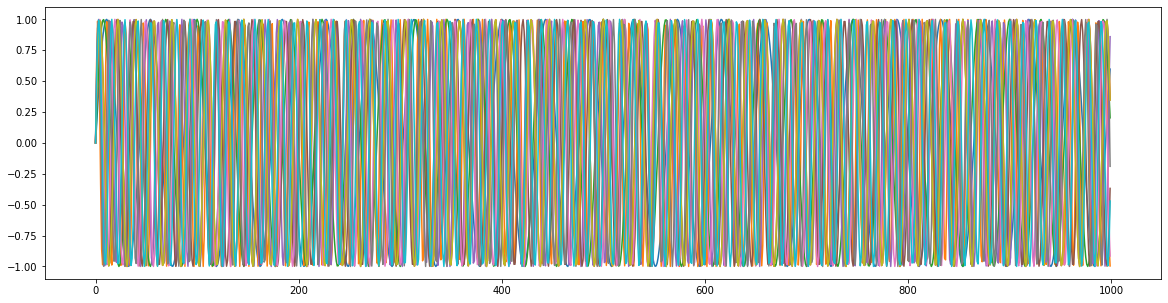

In [33]:
synth_data = make_synthetic_datasets(1, 10, 1000)
plt.figure(figsize=(20,5))
plt.plot(synth_data.T)

In [86]:
n_samples = 1000
n_samples_valid = 200
n_channels = 50
seq_len = 50000
generate_dataset = True

In [87]:
! rm ../../data/synth_multi_gauss/synth_multi_gauss_train.h5
! rm ../../data/synth_multi_gauss/synth_multi_gauss_test.h5

rm: cannot remove '../../data/synth_multi_gauss/synth_multi_gauss_train.h5': No such file or directory
rm: cannot remove '../../data/synth_multi_gauss/synth_multi_gauss_test.h5': No such file or directory


In [88]:
if generate_dataset:
    output_path = '../../data/synth_multi_gauss/synth_multi_gauss_train.h5'
    synth_data_preprocessing(n_samples, n_channels, seq_len, output_path)

In [89]:
if generate_dataset:
    output_path = '../../data/synth_multi_gauss/synth_multi_gauss_test.h5'
    synth_data_preprocessing(n_samples_valid, n_channels, seq_len, output_path)

In [90]:
class MultivariateSynthGauss_dataset(Dataset):
    
    def __init__(self, data_path, seq_len, batch_size):
        
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.data = h5py.File(data_path, 'r')
        self.file_list = list(self.data.keys())
        self.file_list = self.file_list[:(len(self.file_list)//batch_size)*batch_size]
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        filename = self.file_list[idx]
        audio_file = self.data[filename][()]
        len_file = audio_file.shape[1]
        rnd_idx = np.random.randint(0, len_file-self.seq_len)
        audio_sample = audio_file[:, rnd_idx:rnd_idx+self.seq_len]
        #audio_sample = audio_sample.reshape(1,-1)
        
        return audio_sample

In [91]:
class CPC(nn.Module):

    def __init__(self, n_timesteps, n_samples, n_channels, seq_len):
        
        super(CPC, self).__init__()
        
        self.n_timesteps = n_timesteps
        self.n_samples = n_samples
        self.seq_len = seq_len
        self.comp_rate = 160
        self.n_channels = n_channels

        self.g_enc = nn.Sequential(
            
                        nn.Conv1d(n_channels, 512, stride=5, kernel_size=10, padding=3, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=4, kernel_size=8, padding=2, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True)

                         )

        # autoregressive unit
        self.g_ar = nn.GRU(512, 256, batch_first=True)

        # list of W for each k timestep
        # note the input=256 from the GRU, output=512 to match the size of z
        self.W = nn.ModuleList([nn.Linear(256,512) for t in range(self.n_timesteps)])

        # softmax function to compute the prediction
        self.softmax = nn.Softmax(dim=0)

        # log softmax function to compute final loss
        self.log_softmax = nn.LogSoftmax(dim=0)


        def weights_initialization(module):

            if type(module) == nn.Conv1d:
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')

            elif type(module) == nn.BatchNorm1d:
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

            elif type(module) == nn.Linear:
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')

            elif type(module) == nn.GRU:
                for name, param in module.named_parameters():
                    if 'weight' in name:
                        nn.init.kaiming_normal_(param.data, mode='fan_out', nonlinearity='relu')


        self.apply(weights_initialization)



    # hidden state initialization with zeros for first gru loop
    def initialize_hidden(self, gpu=True): # n_samples should be passed as a parameter, allows more freedom to train with different batch sizes
        
        if gpu:
            hidden = torch.zeros(1, self.n_samples, self.g_ar.hidden_size).cuda()
            # hidden = torch.zeros(1, self.n_samples, self.g_ar.hidden_size).to(device)
        else:
            hidden = torch.zeros(1, self.n_samples, self.g_ar.hidden_size)
            
        return hidden
    
    
    def forward(self, X, hidden, device):
        
        # n_samples should be passed as a parameter, allows more freedom to train with different batch sizes
        
        z = self.g_enc(X)
        z = z.transpose(1,2)

        t = torch.randint(1, self.seq_len // self.comp_rate - self.n_timesteps, size=(1,))
#         print('random time sample: ',t)
        
        c_t = z[:,:t,:]
        c_t, hidden = self.g_ar(c_t)
        c_t = c_t[:,t-1,:].view(self.n_samples, 256)

        loss = 0
        acc = []

        for k in range(n_timesteps):

            w_k = self.W[k]
            y_k = w_k(c_t)

            z_k = z[:,t+k,:].view(self.n_samples,512)      

            f_k = torch.mm(z_k, y_k.transpose(0,1))
            
            # compute loss
            loss_k = self.log_softmax(f_k)
            loss_k = torch.diagonal(loss_k)
            loss_k = torch.sum(loss_k)

            loss += loss_k
            
            # compute correct output
            pred_k = self.softmax(f_k)
            pred_k = torch.argmax(pred_k, dim=0)
            
            gt_k = torch.arange(0, self.n_samples, device=device)
            
            corr_k = torch.eq(pred_k,gt_k)
            corr_k = torch.sum(corr_k)
            acc_k = corr_k.item()/self.n_samples
            
            acc.append(acc_k)
            

        loss *= -1
        loss /= self.n_samples*self.n_timesteps
        

        return loss, acc, hidden
    
    
    def predict(self, X, hidden):
        
        z = self.g_enc(X)
        z = z.transpose(1,2)
        c_t, hidden = self.g_ar(z)
        
        return c_t[:,-1,:], hidden

In [92]:
class CPC_small(nn.Module):

    def __init__(self, n_timesteps, n_samples, n_channels, seq_len):
        
        super(CPC_small, self).__init__()
        
        self.n_timesteps = n_timesteps
        self.n_samples = n_samples
        self.seq_len = seq_len
        self.comp_rate = 3.77
        self.n_channels = n_channels

        self.g_enc = nn.Sequential(
            
                        nn.Conv1d(n_channels, 512, stride=2, kernel_size=4, padding=3, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=2, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=1, kernel_size=2, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=1, kernel_size=2, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=1, kernel_size=2, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True)

                         )

        # autoregressive unit
        self.g_ar = nn.GRU(512, 256, batch_first=True)

        # list of W for each k timestep
        # note the input=256 from the GRU, output=512 to match the size of z
        self.W = nn.ModuleList([nn.Linear(256,512) for t in range(self.n_timesteps)])

        # softmax function to compute the prediction
        self.softmax = nn.Softmax(dim=0)

        # log softmax function to compute final loss
        self.log_softmax = nn.LogSoftmax(dim=0)


        def weights_initialization(module):

            if type(module) == nn.Conv1d:
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')

            elif type(module) == nn.BatchNorm1d:
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

            elif type(module) == nn.Linear:
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')

            elif type(module) == nn.GRU:
                for name, param in module.named_parameters():
                    if 'weight' in name:
                        nn.init.kaiming_normal_(param.data, mode='fan_out', nonlinearity='relu')


        self.apply(weights_initialization)



    # hidden state initialization with zeros for first gru loop
    def initialize_hidden(self, gpu=True): # n_samples should be passed as a parameter, allows more freedom to train with different batch sizes
        
        if gpu:
            hidden = torch.zeros(1, self.n_samples, self.g_ar.hidden_size).cuda()
            # hidden = torch.zeros(1, self.n_samples, self.g_ar.hidden_size).to(device)
        else:
            hidden = torch.zeros(1, self.n_samples, self.g_ar.hidden_size)
            
        return hidden
    
    
    def forward(self, X, hidden, device):
        
        # n_samples should be passed as a parameter, allows more freedom to train with different batch sizes
        
        z = self.g_enc(X)
        z = z.transpose(1,2)

        t = torch.randint(1, int(self.seq_len // self.comp_rate - self.n_timesteps), size=(1,))
#         print('random time sample: ',t)
        
        c_t = z[:,:t,:]
        c_t, hidden = self.g_ar(c_t)
        c_t = c_t[:,t-1,:].view(self.n_samples, 256)

        loss = 0
        acc = []

        #print(z[:,t:,:].shape)

        for k in range(self.n_timesteps):

            w_k = self.W[k]
            y_k = w_k(c_t)

            z_k = z[:,t+k,:].view(self.n_samples,512)      

            f_k = torch.mm(z_k, y_k.transpose(0,1))
            
            # compute loss
            loss_k = self.log_softmax(f_k)
            loss_k = torch.diagonal(loss_k)
            loss_k = torch.sum(loss_k)

            loss += loss_k
            
            # compute correct output
            pred_k = self.softmax(f_k)
            pred_k = torch.argmax(pred_k, dim=0)
            
            gt_k = torch.arange(0, self.n_samples, device=device)
            
            corr_k = torch.eq(pred_k,gt_k)
            corr_k = torch.sum(corr_k)
            acc_k = corr_k.item()/self.n_samples
            
            acc.append(acc_k)
            

        loss *= -1
        loss /= self.n_samples*self.n_timesteps
        

        return loss, acc, hidden
    
    
    def predict(self, X, hidden):
        
        z = self.g_enc(X)
        z = z.transpose(1,2)
        c_t, hidden = self.g_ar(z)
        
        return c_t[:,-1,:], hidden

In [93]:
def train(model, optimizer, train_dataloader, device):

    model.train()
    total_train_loss = 0
    total_train_acc = []

    for idx_batch, batch in enumerate(train_dataloader):

        optimizer.zero_grad()

        hidden = model.initialize_hidden(gpu=gpu)
        loss, acc, hidden = model.forward(batch.float().to(device), hidden, device)

        loss.backward()
        optimizer.step()
        
        total_train_loss += len(batch) * loss
        total_train_acc.append(acc)

    total_train_loss /= len(train_dataloader.dataset)

    return total_train_loss, total_train_acc


def validation(model, valid_dataloader, device):

    model.eval()
    total_val_loss = 0
    total_val_acc = []


    with torch.no_grad():
        for idx_batch, batch in enumerate(valid_dataloader):
    #             print(batch.size())
            hidden = model.initialize_hidden(gpu=gpu)
            val_loss, val_acc, hidden = model.forward(batch.float().to(device), hidden, device=device)
            total_val_loss += len(batch) * val_loss
            total_val_acc.append(val_acc)


    total_val_loss /= len(valid_dataloader.dataset)
    
    return total_val_loss, total_val_acc

In [94]:
24*14

336

In [97]:
train_data_path = '../../data/synth_multi_gauss/synth_multi_gauss_train.h5'
valid_data_path = '../../data/synth_multi_gauss/synth_multi_gauss_test.h5'
gpu = True
#seq_len = 20480
seq_len = 24*14
comp_rate = 3 #160
n_timesteps = 12
n_samples = 8
n_channels = 50


synth_train = MultivariateSynthGauss_dataset(train_data_path,seq_len,n_samples)
synth_valid = MultivariateSynthGauss_dataset(valid_data_path,seq_len,n_samples)

In [98]:
train_dataloader = DataLoader(synth_train, batch_size=n_samples, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(synth_valid, batch_size=n_samples, shuffle=True, num_workers=0)

In [99]:
device = torch.device('cuda:0')
cpc_test = CPC_small(n_timesteps, n_samples, n_channels, seq_len).to(device)
train_params = [p for p in cpc_test.parameters() if p.requires_grad == True]
optimizer = optim.Adam(train_params)

-- epoch 0 --
train loss: 4.788434028625488
valid loss: 2.983992338180542


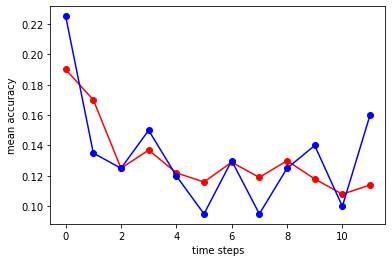

-- epoch 1 --
train loss: 2.4737918376922607
valid loss: 2.237884521484375
-- epoch 2 --
train loss: 2.1763675212860107
valid loss: 2.1491754055023193
-- epoch 3 --
train loss: 2.1255929470062256
valid loss: 2.107929229736328
-- epoch 4 --
train loss: 2.108448028564453
valid loss: 2.0942513942718506
-- epoch 5 --
train loss: 2.096337080001831
valid loss: 2.091254949569702
-- epoch 6 --
train loss: 2.0847065448760986
valid loss: 2.083575963973999
-- epoch 7 --
train loss: 2.085829496383667
valid loss: 2.0725338459014893
-- epoch 8 --
train loss: 2.065558910369873
valid loss: 2.046213388442993
-- epoch 9 --
train loss: 2.021897792816162
valid loss: 1.9535104036331177
-- epoch 10 --
train loss: 1.959455132484436
valid loss: 1.9133597612380981


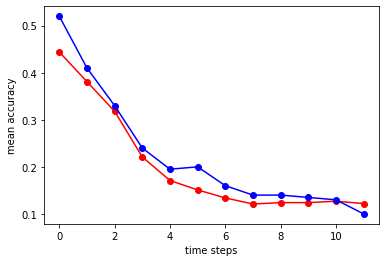

-- epoch 11 --
train loss: 1.8774995803833008
valid loss: 1.7932751178741455
-- epoch 12 --
train loss: 1.808823823928833
valid loss: 1.7889376878738403
-- epoch 13 --
train loss: 1.7547929286956787
valid loss: 1.7556830644607544
-- epoch 14 --
train loss: 1.7173399925231934
valid loss: 1.7044967412948608
-- epoch 15 --
train loss: 1.6922498941421509
valid loss: 1.655415654182434
-- epoch 16 --
train loss: 1.6265978813171387
valid loss: 1.528511643409729
-- epoch 17 --
train loss: 1.2872989177703857
valid loss: 1.0299527645111084
-- epoch 18 --
train loss: 0.8026748895645142
valid loss: 0.7503382563591003
-- epoch 19 --
train loss: 0.6856967210769653
valid loss: 0.6149778366088867


In [100]:
for epoch in range(20):

    total_train_loss, total_train_acc = train(cpc_test, optimizer, train_dataloader, device)
    total_valid_loss, total_valid_acc = validation(cpc_test, valid_dataloader, device)
    
    print('-- epoch {0} --'.format(epoch))
    print('train loss: {0}'.format(total_train_loss))
    print('valid loss: {0}'.format(total_valid_loss))
    
    if epoch%10==0:
        plt.plot(np.mean(total_train_acc,0),'r-o')
        plt.ylabel('mean accuracy')
        plt.xlabel('time steps')

        plt.plot(np.mean(total_valid_acc,0),'b-o')
        plt.ylabel('mean accuracy')
        plt.xlabel('time steps')
    
    plt.show()

Text(0.5, 0, 'time steps')

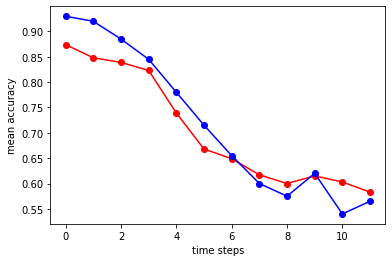

In [101]:
        plt.plot(np.mean(total_train_acc,0),'r-o')
        plt.ylabel('mean accuracy')
        plt.xlabel('time steps')

        plt.plot(np.mean(total_valid_acc,0),'b-o')
        plt.ylabel('mean accuracy')
        plt.xlabel('time steps')

In [102]:
test_data = torch.from_numpy(np.array([make_synthetic_datasets(10, 50, 5000) for _ in range(100)])).float().to(device)

In [103]:
test_data.shape

torch.Size([100, 50, 5000])

In [104]:
hidden = cpc_test.initialize_hidden(gpu=True)
cpc_embedding, hidden = cpc_test.predict(test_data, hidden)

In [105]:
cpc_embedding.shape

torch.Size([100, 256])

In [106]:

cpc_embedding = cpc_embedding.contiguous().view((-1, 256))
cpc_embedding = cpc_embedding.cpu().detach().numpy()

In [107]:
cpc_embedding.shape

(100, 256)

In [108]:
from sklearn.manifold import TSNE

/home/giovanni/anaconda3/envs/crypto/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/giovanni/anaconda3/envs/crypto/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


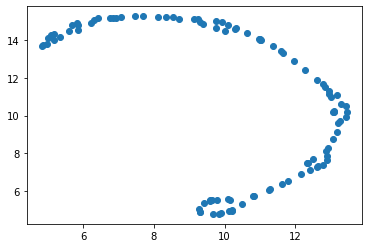

In [109]:
tsne_spk_emb = TSNE(n_components=2).fit_transform(cpc_embedding)
plt.scatter(tsne_spk_emb[:,0],tsne_spk_emb[:,1])

In [71]:
g_enc = nn.Sequential(
            
                        nn.Conv1d(n_channels, 512, stride=5, kernel_size=10, padding=3, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=4, kernel_size=8, padding=2, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True)

                         )

In [92]:
padding=[3, 2, 1, 1, 1]
seq_len = 24*14
seq_len = 20480
dilation = [1, 1, 1, 1, 1]
kernel_size= [10, 8, 4, 4, 4]
stride= [5, 4, 2, 2, 2]

n_layers = 5


for l in range(n_layers):

    seq_len = (seq_len+2*padding[l]-dilation[l]*(kernel_size[l]-1)-1)/stride[l]+1
    print(seq_len)

4096.2
1024.05
512.025
256.0125
128.00625


In [76]:
20480/128

160.0

In [108]:
24*14 / 6.78

49.557522123893804

In [122]:
padding=[3, 2, 1, 1, 1]
seq_len = 24*14
#seq_len = 20480
dilation = [1, 1, 1, 1, 1]
kernel_size= [4, 4, 2, 2, 2]
stride= [2, 2, 1, 1, 1]

n_layers = 5


for l in range(n_layers):

    seq_len = (seq_len+2*padding[l]-dilation[l]*(kernel_size[l]-1)-1)/stride[l]+1
    print(seq_len)

170.0
86.0
87.0
88.0
89.0


In [123]:
24*14 / 89

3.7752808988764044

In [18]:
int(24*14 // 3.77 - n_timesteps)

77

In [110]:
n_timesteps

12

In [111]:
24*14 // 49

6